<a href="https://colab.research.google.com/github/Jitpanu-Chai/Mask-RCNN/blob/main/Pytorch_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

In [2]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
device = 'CUDA' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [4]:
COCO__INSTANCE_CATEGORY_NAMES = [  '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',  'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [5]:
len(COCO__INSTANCE_CATEGORY_NAMES) #91 class including background

91

In [6]:
from PIL import Image
from torchvision import transforms as T
import numpy as np
import requests
from io import BytesIO

In [7]:
def get_predition(img_path,threshold=0.5,url=False):
    if url: #web image
        response = requests.get(img_path)
        img = Image.open(BytesIO(response.content))
    else: #local image
        img = Image.open(img_path)
    
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])     
    #Extract bounding boxs and masks
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x >= threshold][-1]
    masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO__INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxs = [ [(i[0],i[1]),(i[2],i[3])] for i in list(pred[0]['boxes'].detach().numpy()) ]

    masks = masks[:pred_t+1]
    pred_boxs = pred_boxs[:pred_t+1]
    pred_class = pred_class[:pred_t+1]

    return masks,pred_boxs,pred_class


In [8]:
ssd = get_predition('https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*',url=True)

In [9]:
ssd

(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]),
 [[(463.88074, 45.46334), (822.1696, 575.73914)]],
 ['dog'])

In [10]:
import matplotlib.pyplot as plt
import cv2

In [11]:
from urllib.request import urlopen
def url_to_image(url,readFlag=cv2.IMREAD_COLOR):
    response = urlopen(url) #turn url to image for drawing masks and bounding boxes
    image = np.asarray(bytearray(response.read()), dtype='uint8')  
    image = cv2.imdecode(image, readFlag)
    return image

In [12]:
import random
def random_color_mask(image):
    color_list = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    r[image==1],g[image==1],b[image==1] = color_list[random.randrange(0,10)]
    colored_mask = np.stack([r,g,b],axis=2)
    return colored_mask

In [13]:
def instance_segmentation(img_path,threshold=0.5,react_th=3,text_size=3,text_th=3,url=False):
    mask,box,label= get_predition(img_path,threshold=threshold,url=url)

    if url:
        img = url_to_image(img_path)
    else:
        img = cv2.imread(img_path)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    raw_img = img.copy()

    for i in range(len(mask)):
        rgb_mask = random_color_mask(mask[i])
        img = cv2.addWeighted(img,1,rgb_mask,0.5,0)
        cv2.rectangle(img,box[i][0],box[i][1],color=(0,255,0),thickness=react_th)
        cv2.putText(img,label[i],box[i][0],cv2.FONT_HERSHEY_PLAIN,text_size,(0,255,0),thickness=text_th)

    return img,label,mask,box,raw_img

In [14]:
IMG_PATH = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=1.00xw:0.669xh;0,0.190xh&resize=1200:*'

In [15]:
img,label,mask,box,raw = instance_segmentation(IMG_PATH,url=True)

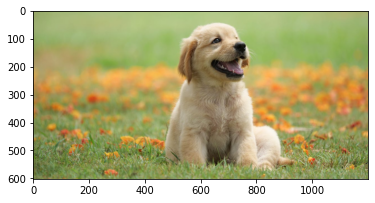

In [16]:
plt.imshow(raw)
plt.show()

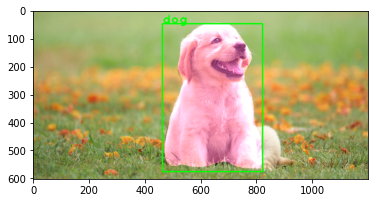

In [17]:
plt.imshow(img)
plt.show()

In [18]:
#can we cut only specific area to another picture

In [19]:
#Method1. Mask direcly 

In [41]:
area_mask = mask.astype(np.uint8).squeeze()

In [42]:
area_mask.shape

(602, 1200)

In [38]:
result = raw.copy()

In [39]:
result.shape

(602, 1200, 3)

In [43]:
result = raw.copy()
result[area_mask==0] = (255,255,255)

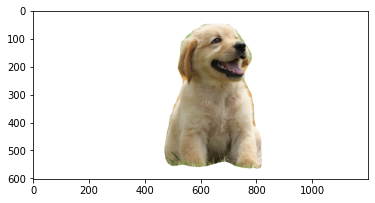

In [44]:
plt.imshow(result)
plt.show()

In [45]:
#then crop

In [49]:
box=box[0]

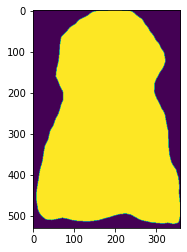

In [50]:
mask_croped = area_mask[int(box[0][1]):int(box[1][1]), int(box[0][0]):int(box[1][0])]
plt.imshow(mask_croped)
plt.show()

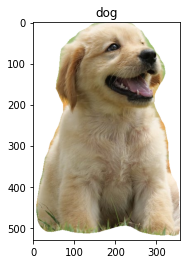

In [51]:
result_croped = result[int(box[0][1]):int(box[1][1]), int(box[0][0]):int(box[1][0])]  #cropp[high,width]
plt.imshow(result_croped)
plt.title(label[0])
plt.show()

In [52]:
#goto space

In [53]:
space_path = 'https://media-exp1.licdn.com/dms/image/C4D1BAQGAO9zvVhyAqQ/company-background_10000/0/1539806088038?e=2147483647&v=beta&t=s-KRqQVJGnDoPraHYu6IQF_wUkKr2CLqyFMUo20XCwE'

In [54]:
space = url_to_image(space_path)
space = cv2.cvtColor(space,cv2.COLOR_BGR2RGB)

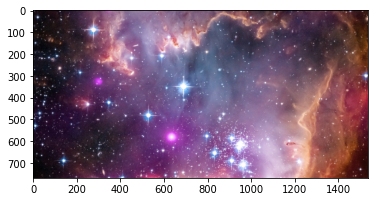

In [55]:
plt.imshow(space)
plt.show()

In [56]:
def find_box(object_img,background_img):
    obj_h,obj_w,_ = object_img.shape
    background_h,background_w,_ = background_img.shape

    assert background_w - obj_w > 0,"background width smaller than object"
    assert background_h - obj_h > 0,"background hight smaller than object"

    #find_point
    while True:
        #rand x
        random_point_x = random.randint(0,background_w)
        random_point_y = random.randint(0,background_h)
        x1=random_point_x
        x2= x1 + obj_w
        y1= random_point_y
        y2= y1 + obj_h

        if x2 <= background_w and y2 <= background_h:
            return (x1,y1),(x2,y2)       

In [57]:
start_p,end_p = find_box(result_croped,space)

In [58]:
start_p,end_p

((498, 132), (857, 662))

In [59]:
#clear white background

In [60]:
def combined_img(object_img,background_img,mask_croped):
    start_p,end_p = find_box(object_img,background_img)

    new_img = background_img.copy()
    new_img[start_p[1]:end_p[1],start_p[0]:end_p[0]] = object_img

    for i in range(start_p[1],end_p[1]): #hight
        for j in range(start_p[0],end_p[0]): #width           
            if new_img[i,j,0] == 255 and new_img[i,j,1] == 255 and new_img[i,j,2] == 255 and mask_croped[i-start_p[1],j-start_p[0]] == 0:
                new_img[i,j,:] = background_img[i,j,:]   
    return new_img

In [61]:
imgsd = combined_img(result_croped,space,mask_croped)

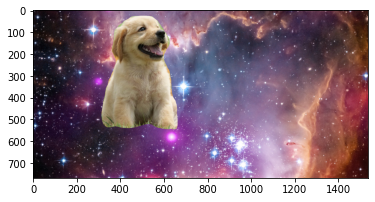

In [62]:
plt.imshow(imgsd)
plt.show()

# **Pipeline segment and cutmix**

In [63]:
def gen_new_img(obj_path,background_path,url_obj=False,url_bg=False): #BG must bigger than obj for both width,height
   
    seg_img,label,mask,box,raw_img = instance_segmentation(obj_path,url=url_obj)

    assert len(label) > 0,"Cannot detect any object"

    area_mask = mask[0].astype(np.uint8)    #take only first object
    raw_img[area_mask==0] = (255,255,255)

    mask_croped = area_mask[int(box[0][0][1]):int(box[0][1][1]), int(box[0][0][0]):int(box[0][1][0])]  #take only first object
    result_croped = raw_img[int(box[0][0][1]):int(box[0][1][1]), int(box[0][0][0]):int(box[0][1][0])]  #take only first object

    if url_bg:
        BG = url_to_image(background_path)
    else:
        BG = cv2.imread(background_path)
    
    BG = cv2.cvtColor(BG,cv2.COLOR_BGR2RGB)

    new_img = combined_img(result_croped,BG,mask_croped)    

    return new_img

In [64]:
OBJ_PATH = 'https://pbs.twimg.com/profile_images/1468830158370926596/pF1UvVo9_400x400.jpg'
BG_PATH = 'https://www.ijconvent.ac.th/images/slider/slider.jpg'

In [65]:
mixed_img = gen_new_img(OBJ_PATH,BG_PATH,url_obj=True,url_bg=True)

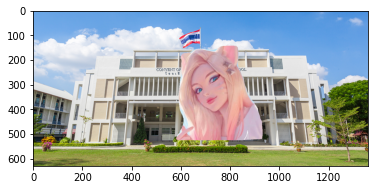

In [66]:
plt.imshow(mixed_img)
plt.show()

# **Multiple instances**

In [67]:
MULTI_PATH = 'https://res.cloudinary.com/dk-find-out/image/upload/q_80,w_1920,f_auto/Animal_kingdom_nzwbda.jpg'
BG_PATH2 = 'https://i.natgeofe.com/n/8a3e578f-346b-479f-971d-29dd99a6b699/nationalgeographic_2751013_16x9.jpg'

In [68]:
seg_img,label,mask,box,raw = instance_segmentation(MULTI_PATH,url=True)

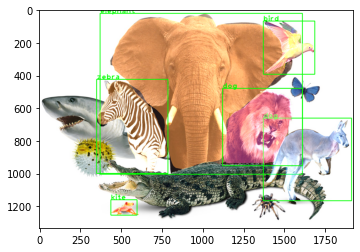

In [69]:
plt.imshow(seg_img)
plt.show()

In [70]:
len(mask)

6

In [71]:
#can we do cutmix for multiple objeoct

In [75]:
def gen_new_img_multiOBJ(obj_path,background_path,url_obj=False,url_bg=False): #BG must bigger than obj for both width,height
   
    seg_img,label,mask,box,raw_img = instance_segmentation(obj_path,url=url_obj)

    assert len(label) > 0,"Cannot detect any object"

    if url_bg:
        BG = url_to_image(background_path)
    else:
        BG = cv2.imread(background_path)

    BG = cv2.cvtColor(BG,cv2.COLOR_BGR2RGB)

    for i in range(len(mask)):

        area_mask = mask[i].astype(np.uint8)
        clear_bg_image = raw_img.copy()
        clear_bg_image[area_mask==0] = (255,255,255)        

        mask_croped = area_mask[int(box[i][0][1]):int(box[i][1][1]), int(box[i][0][0]):int(box[i][1][0])]
        result_croped = clear_bg_image[int(box[i][0][1]):int(box[i][1][1]), int(box[i][0][0]):int(box[i][1][0])]

        new_img = combined_img(result_croped,BG,mask_croped)   
        BG = new_img

    return new_img

In [76]:
multi_mixed_img = gen_new_img_multiOBJ(MULTI_PATH,BG_PATH2,url_obj=True,url_bg=True)

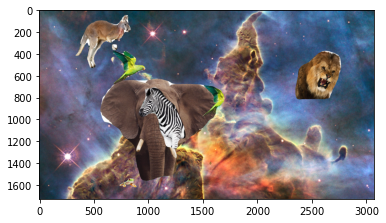

In [77]:
plt.imshow(multi_mixed_img)
plt.show()

# **Is Possible to create yolo tag from this?**